# <div class="alert alert-info"> 1. Overview </div>

## <font color=red>1.1.  Introduction</font>

1. **Problem**: The vast majority of the available data is actually unlabeled, so there is a huge potential in unsupervised learning that we can invest into. For instance, Topic modeling is one of the application of Unsupervised techniques. It is used to extract and depict key themes or topics which are latent in a large corpora of text documents.  

2. **Objective**: This analysis combines techniques in NLP and Unsupervised learning to perform the task of topic modeling. These techniques are described in the following section

## <font color=red>1.2. Techniques</font>

### <font color=blue>1. Text Preprocessing and Normalization
Before feature engineering, we need to  pre-process, clean, and normalize text.
    

### <font color=blue>2. Word Embedding for Feature Extraction 
    
1. **Word Embedding technique**: For feature extraction, Word embedding is applied to transform each word to a numeric vector. Each word is assigned its own vector in such a way that words that frequently appear together in the same context are given vectors that are close together. So similar meaning words have similar representations, these vectors try to capture contextual and semantic information.
    
2. **Word2vec Model with gensim**: This part employes the Word2vec model which was released by Google in 2013 and trained on the Google News dataset (about 100 billion words). This step will transform each worrd to a numeric vector of 300 features and this high dimensionality dataset can expose some problems in Machine Learning model knnown as the curse of dimensionality.

3. **The curse of dimensionality**: Many Machine Learning algorithms have problems involving high dimensionality of features for each training instance. This makes it not only difficult to understand or explore the pattern of data, training time extremely slow, parameter estimation challenging, but also affects the machine learning model's performance since there are more chances to overfit the model or violate some of the assumptions of the algorithm. The problem is often referred to as the curse of dimensionality

### <font color=blue>3. Dimensionality Reduction with PCA and AutoEncoder
1. **Dimensionality Reduction with PCA and AutoEncoder**: This is where dimensionality reduction comes in. Dimensionality reduction is the process of reducing the number of random variables by obtaining a set of principal variables but still keep important information. The new variables are then used for downstream task such as Regression, Classification or Clustering
    
2. **Dimensionality Reduction with TSNE**: TSNE is a Dimensionality reduction technique which is extremely useful for data visualization. Reducing the number of dimensions down to two (or three) makes it possible to plot a condensed view of high-dimensional training set on a graph and often get better understand by visually detecing patterns, such as clusters.

### <font color=blue>4. Clustering 

1. **Intuition**: Clustering is an unsupervesed learning method that divide the data points into a number of groups, such that the data points in the same groups have similar properties and data points in different groups have different properties in some sense. Unsupervised learning means that there is no outcome to be predicted, and the algorithm just tries to find patterns in the data. Clusters found are represented topics in topic modeling problem

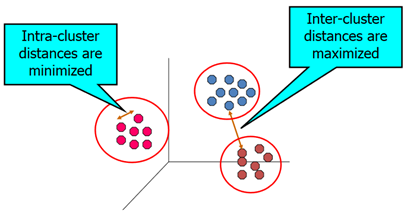

2. **Types of clustering**: There is no univerrsal definition of what a cluster is: it really depends on the context, and different algorithms will capture different kinds of clusters. For example, some algorithm look for instances centered around a particular point, called centroid (KMeans, Gaussian Mixure). Others look for continous regions of densely packed instances: these clusters can take on any shape (DBScan). Some algorithms are hierarchical, looking for clusters of clusters (Agglomerative Clustering). The following pic is to depict clustering of different algorithm. 

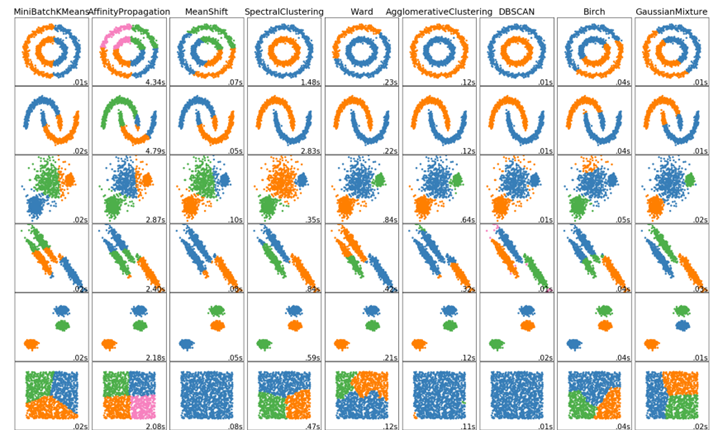

## <font color=red>1.3. Findings</font>
1. For text data, AutoEncoder outperforms PCA in compressing data in a way to represent pattern better
2. One of the good practice in order to determine which algorithm is the most appropriate for a given dataset is trying to visualize data on a 2D space and looking for the pattern. The result is then verified by business users or experts of the field

---
# <div class="alert alert-info"> 2. Setup </div>

 ## <font color=red>2.1. Import library</font>

In [54]:
import joblib
import sys
import sklearn
import pandas as pd
import numpy as np

## for data
import collections
import json

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing text data
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string
import re
from bs4 import BeautifulSoup
import unicodedata

# for calculating similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import  LabelEncoder

## for word embedding
import gensim
import gensim.downloader as gensim_api
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
# deep learning library
from keras.models import *
from keras.layers import *
from keras.callbacks import *

# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# display various ranges 
pd.options.display.float_format = '{:.3f}'.format

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

print('Python: {}'.format(sys.version))
print('NLTK: {}'.format(nltk.__version__))
print('Scikit-learn: {}'.format(sklearn.__version__))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('gensim: {}'.format(gensim.__version__))
print("Setup complete...")

Python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
NLTK: 3.6.5
Scikit-learn: 0.23.2
Pandas: 1.3.3
Numpy: 1.21.2
gensim: 3.8.3
Setup complete...


 ## <font color=red>2.2. Utitlity functions</font>

In [3]:
def plot_cluster(X, y):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    ax[0].scatter(X[:,0], X[:,1], s=5)
    ax[1].scatter(X[:,0], X[:,1], c=y, s=5, cmap='jet')
    plt.axis("off")
    plt.show()

---
# <div class="alert alert-info"> 3. Data Preparation </div>

The dataset used is “News category dataset” from Kaggle (https://www.kaggle.com/rmisra/news-category-dataset). This dataset is around 200k news headlines from the year 2012 to 2018 obtained from HuffPost. The original dataset contains over 30 categories, but for the purposes of this analysis, I will work with a subset of 4: TRAVEL, FOOD & DRINK, BUSINESS, SPORTS

 
 The following steps are applied for converting text data to numeric features:
 
 + Detect language and filter only English
 + Preprocessing & Normalize text
 + Split data into train set and test set
 + Feature Extraction using word embedding with Word2Vec model
 + Scaling independent features
 + Convert target from categorical data to numeric data

 ## <font color=red>3.1.  Load dataset</font>

In [58]:
df = pd.read_csv('News_Category.csv')
print(df.shape)
## print 5 random rows
df = df.reset_index(drop=True)
df.head(5)

(26768, 4)


category                                           headline                                  short_description                                               text
0  BUSINESS  U.S. Launches Auto Import Probe, China Vows To...  The investigation could lead to new U.S. tarif...  U.S. Launches Auto Import Probe, China Vows To...
1  BUSINESS  Starbucks Says Anyone Can Now Sit In Its Cafes...  The new policy was unveiled weeks after the co...  Starbucks Says Anyone Can Now Sit In Its Cafes...
2  BUSINESS  Seattle Passes Controversial New Tax On City's...  Following the council vote, Amazon’s vice pres...  Seattle Passes Controversial New Tax On City's...
3  BUSINESS  Uber Ends Forced Arbitration In Individual Cas...  Victims will be free to go to court -- but a f...  Uber Ends Forced Arbitration In Individual Cas...
4  BUSINESS  Chili's Hit By Data Breach, Credit And Debit C...  The breach is believed to have occurred betwee...  Chili's Hit By Data Breach, Credit And Debit C...

Column 'text' is the concatenation of column 'headline' and 'short_description'. The analysis use column 'text'  to cluster data

View column text in the first five rows

In [56]:
for i in range(0,5):
    print(df.text[i])
    print('\n')

U.S. Launches Auto Import Probe, China Vows To Defend Its Interests. The investigation could lead to new U.S. tariffs similar to those imposed on imported steel and aluminum in March.


Starbucks Says Anyone Can Now Sit In Its Cafes -- Even Without Buying Anything. The new policy was unveiled weeks after the controversial arrest of two black men at a Philadelphia Starbucks.


Seattle Passes Controversial New Tax On City's Biggest Companies To Combat Housing Crisis. Following the council vote, Amazon’s vice president, Drew Herdener, said the company has resumed construction planning for its so-called Block 18 project in downtown Seattle.


Uber Ends Forced Arbitration In Individual Cases Of Sexual Assault, Harassment. Victims will be free to go to court -- but a few caveats remain.


Chili's Hit By Data Breach, Credit And Debit Card Information Compromised. The breach is believed to have occurred between March and April.




 ## <font color=red>3.2.  Text Preprocesing</font>

### <font color=blue>1. Detect Language</font>

In [59]:
import langdetect

df["text"] = df["text"].astype(str)
df['lang'] = df["text"].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")
df = df[df["lang"]=="en"]
df.shape

(24890, 5)

### <font color=blue>2. Normalizing text</font>

Before feature engineering, we need to  pre-process, clean, and normalize text. Following are some of the popular pre-processing techniques:

**1. Text tokenization and lower casting**: Split doc into individual words and lower casting all words <br>
**2. Removing special characters**: remove special characters and punctuations <br>
**3. Removing stop words**: Words like "a" and "the" appear so frequently and  are called stop words, they can be filtered from the text to be processed <br>
**4. Stemming**: extract root of words by remove -ing, -ly, -ed... <br>
**5. Lemmatization**: In contrast to stemming, lemmatization looks beyond word reduction, and considers a language's full vocabulary to apply a *morphological analysis* to words. The lemma of 'was' is 'be' and the lemma of 'mice' is 'mouse'. Further, the lemma of 'meeting' might be 'meet' or 'meeting' depending on its use in a sentence. <br>

In [57]:
def normalize_text(text, flg_stemm=False, flg_lemm=False, lst_stopwords=None):
    
    ## clean (convert to lowercase and remove punctuations and   characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub('[^a-zA-Z\s]', '', text)
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [8]:
lst_stopwords = nltk.corpus.stopwords.words("english")

df["text_clean"] = df["text"].apply(lambda x: normalize_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=lst_stopwords))

df.head()

category                                           headline                                  short_description                                               text lang                                         text_clean
0  BUSINESS  U.S. Launches Auto Import Probe, China Vows To...  The investigation could lead to new U.S. tarif...  U.S. Launches Auto Import Probe, China Vows To...   en  u launch auto import probe china vow defend in...
1  BUSINESS  Starbucks Says Anyone Can Now Sit In Its Cafes...  The new policy was unveiled weeks after the co...  Starbucks Says Anyone Can Now Sit In Its Cafes...   en  starbuck say anyon sit cafe even without buy a...
2  BUSINESS  Seattle Passes Controversial New Tax On City's...  Following the council vote, Amazon’s vice pres...  Seattle Passes Controversial New Tax On City's...   en  seattl pas controversi new tax citi biggest co...
3  BUSINESS  Uber Ends Forced Arbitration In Individual Cas...  Victims will be free to go to court -- but a f...  Uber Ends Forced Arbitration In Individual Cas...   en  uber end forc arbitr individu case sexual assa...
4  BUSINESS  Chili's Hit By Data Breach, Credit And Debit C...  The breach is believed to have occurred betwee...  Chili's Hit By Data Breach, Credit And Debit C...   en  chili hit data breach credit debit card inform...

In [9]:
df.shape

(24893, 6)

In [60]:
df = pd.read_csv('normalized_News_Category.csv')

### <font color=blue>Split dataset to train and test set</font>

In [61]:
## split dataset
df.rename(columns={'category':'y'}, inplace=True)
df_train, df_test = model_selection.train_test_split(df, test_size=0.1, random_state=9)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
## get target
y_train = df_train["y"].values
y_test = df_test["y"].values

In [62]:
df_train.head()

y                                           headline                                  short_description                                               text lang                                         text_clean
0        SPORTS  Elect To Watch All 13 Of Stephen Curry's Recor...                                          Just wow.  Elect To Watch All 13 Of Stephen Curry's Recor...   en  elect watch stephen curri recordbreak pointer wow
1        TRAVEL  Delta Air Lines Resumes Flights After Computer...  The company said via Twitter that it had cance...  Delta Air Lines Resumes Flights After Computer...   en  delta air line resum flight comput system suff...
2  FOOD & DRINK           Ultimate Baked Artichoke And Spinach Dip  I love artichoke and spinach dip, especially s...  Ultimate Baked Artichoke And Spinach Dip. I lo...   en  ultim bake artichok spinach dip love artichok ...
3        SPORTS  A Guy With 'Trump Sucks' On His Chest Was Cuff...               How long until the election is over?  A Guy With 'Trump Sucks' On His Chest Was Cuff...   en      guy trump suck chest cuf nba final long elect
4        SPORTS  NFL Reporter Levels Troll With Hard-Earned Com...                        Score one for Stacey Dales.  NFL Reporter Levels Troll With Hard-Earned Com...   en  nfl report level troll hardearn comeback score...

In [63]:
df_test.head()

y                                           headline                                  short_description                                               text lang                                         text_clean
0  FOOD & DRINK  Got Cantaloupe And Honeydew? Here Are The Reci...  You'll be needing one a day for the rest of su...  Got Cantaloupe And Honeydew? Here Are The Reci...   en  got cantaloup honeydew recip need youll need o...
1        SPORTS  Liverpool Tops Manchester United 1-0: Daniel S...  The rivalry between the two sides began to int...  Liverpool Tops Manchester United 1-0: Daniel S...   en  liverpool top manchest unit daniel sturridg go...
2        SPORTS  California Becomes First State To Ban 'Redskin...                    "This issue is not going away."  California Becomes First State To Ban 'Redskin...   en  california becom first state ban redskin team ...
3        SPORTS  Chile Retain Copa With Shootout Win Over Argen...  EAST RUTHERFORD, New Jersey, June 26 (Reuters)...  Chile Retain Copa With Shootout Win Over Argen...   en  chile retain copa shootout win argentina east ...
4        TRAVEL     The Calm Before (and During) the Holiday Storm  Stress and anxiety can ruin yuletide festiviti...  The Calm Before (and During) the Holiday Storm...   en  calm holiday storm stress anxieti ruin yuletid...

In [64]:
df_test.iloc[4].text

'The Calm Before (and During) the Holiday Storm. Stress and anxiety can ruin yuletide festivities, but rest assured, there are ways to embrace the insanity - in fact, every global culture has methods of keeping cool in tense times.'

#### Inspect unique values of y

In [65]:
df_train.y.value_counts()

TRAVEL          8481
FOOD & DRINK    5551
BUSINESS        4590
SPORTS          3777
Name: y, dtype: int64

It can be seen that news are divided into 4 categories represent 4 different topics need to be discovered using clustering techniques

 ## <font color=red>**3.3.  Feature Engineering**

### <font color=blue> Word Embedding technique
Word embedding is applied to transform each word to a numeric vector. Each word is assigned its own vector in such a way that words that frequently appear together in the same context are given vectors that are close together. So similar meaning words have similar representations, these vectors try to capture contextual and semantic information. 

1. Basically, a word embedding not only converts the word but also identifies the semantics and syntaxes of the world to build a vector representation of this information. The underlying concept is to use information from the words adjacent to the word.  
2. For example, the word for “lion” will be closer in value to “cat” than to “dandelion”
    
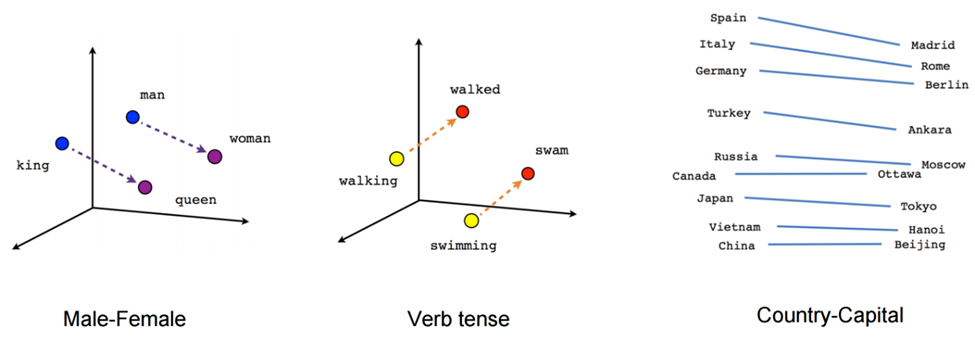
    
3. Some popular word embedding techniques include Word2Vec, GloVe, ELMo, FastText, etc    

### <font color='blue'>**Word embedding using Gensim Framework - word2vec**
    
1. The word2vec model was released by Google in 2013 and uses a neural network based implementation with architectures like continuous Bag of Words and Skip-Grams to learn the distributed vector representation of words in a corpus

2. Depending on the way the embeddings are learned, Word2Vec is classified into two approaches: Continuous Bag-of-Words (CBOW) model learns the focus word given the neighboring words whereas the Skip-gram model learns the neighboring words given the focus word. That’s why Continuous Bag Of Words and Skip-gram are inverses of each other
    
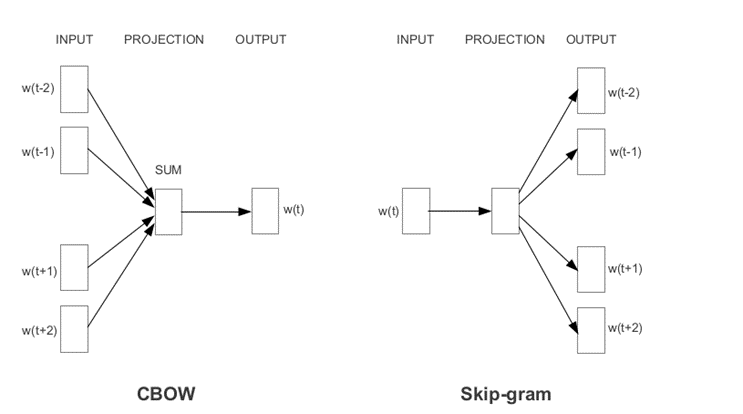

We will be using genism framework to implement the same model on our corpus to extract features. Some of the important parameters in the model are explained briefly as follows
+ Size: Represents the feature vector size for each word in the corpus when transformed
+ Window: Sets the context window size specifying the length of the window of words to be taken into account as belonging to a single, similar context when training
+ Min_count: Specifies the minimum word frequency value needed across the corpus to consider the word as a part of the final vocabulary during training the model
+ Sample: Used to downsample the effects of words which occur very frequently


#### create a corpus of word for both train set  and test set

In [66]:
# Set values for various parameters
feature_size = 300   # Word vector dimensionality
window_context= 30   # Context window size
min_word_count = 1  # Minimum word count
sample = 1e-3        # Downsample setting for frequent words

tokenized_corpus = []
for words in df_train['text_clean']:
    tokenized_corpus.append(words.split())
    
pretrained_model = Word2Vec(size=feature_size, window=window_context, min_count=min_word_count, workers=-1)
pretrained_model.build_vocab(tokenized_corpus)

In [67]:
pretrained_model.similarity('train','cat'),pretrained_model.similarity('train','travel'),  pretrained_model.similarity('dog','cat')

(0.040647525, -0.042730723, -0.03474054)

### <font color=blue>Word Vectorization using Google's Word2vec Pretrained Word Embedding</font>

This part employes the Word2vec model which was released by Google in 2013 and trained on the Google News dataset (about 100 billion words). It uses a neural network based implementation with architectures like continuous Bag of Words and Skip-Grams to learn the distributed vector representation of words in a corpus

In [68]:
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
pretrained_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)
pretrained_model.train(tokenized_corpus, total_examples=pretrained_model.corpus_count, epochs=5)

(0, 0)

In [69]:
pretrained_model.similarity('train','cat'),pretrained_model.similarity('train','travel'),  pretrained_model.similarity('dog','cat')

(0.08540114, 0.29063696, 0.76094574)

Now in order to create features to represent entire document (field text_clean), we can combine all words in the document by averaging word vector representation, where we simply sum all the word vectors occurring in a document and then divide by the count of word vectors to represent an averaged word vector for the document. After this step, we can use these features to build classification or clustering models

In [70]:
def vectorize(corpus, model):
    # global embeddings
    embeddings = []
    for line in corpus:
        w2v = None
        count = 0
        for word in line.split():
            if word in model.wv.vocab:
                count += 1
                if w2v is None:
                    w2v = model.wv[word]
                else:
                    w2v = w2v + pretrained_model.wv[word]
        if w2v is not None:
            w2v = w2v / count
            # append element to the end of the embeddings list
            embeddings.append(w2v)
        
    return embeddings

In [71]:
embeddings = vectorize(df_train['text_clean'], pretrained_model)
X_train = pd.DataFrame(embeddings)
print(X_train.shape)
X_train.head()

(22399, 300)


0      1      2     3      4      5      6      7      8     9      10     11     12     13     14     15     16    17     18     19     20    21    22     23     24     25     26     27     28     29     30     31     32     33     34     35     36     37     38    39     40     41    42     43     44     45     46     47     48     49     50     51     52     53     54     55     56     57     58     59     60     61     62     63     64     65     66     67     68    69     70     71   \
0  0.038  0.042  0.054 0.046 -0.048 -0.047  0.092 -0.129  0.031 0.079 -0.038 -0.178 -0.009  0.098  0.032  0.097  0.127 0.157  0.041 -0.127  0.028 0.031 0.202 -0.030 -0.045  0.013 -0.022  0.051 -0.002 -0.025 -0.059  0.067 -0.061 -0.049  0.014 -0.142 -0.034  0.164 -0.025 0.115  0.093 -0.043 0.145  0.023 -0.032 -0.029  0.068 -0.073 -0.063 -0.037 -0.080  0.054  0.089  0.020 -0.033  0.061 -0.025 -0.001  0.104 -0.027 -0.075 -0.009 -0.067  0.072 -0.019 -0.093 -0.013  0.037  0.079 0.036  0.056  0.039   
1 -0.020  0.046 -0.011 0.004 -0.056 -0.011 -0.027 -0.145  0.096 0.021 -0.004 -0.083 -0.024 -0.010 -0.019  0.064  0.039 0.038 -0.011 -0.026 -0.023 0.011 0.012 -0.001  0.026 -0.027 -0.116  0.063  0.038  0.015 -0.024 -0.035 -0.075 -0.060 -0.005 -0.029 -0.033  0.023  0.014 0.036 -0.004 -0.038 0.137  0.009  0.048 -0.117 -0.032  0.003 -0.013  0.021 -0.048 -0.010  0.056  0.052 -0.008 -0.058 -0.086 -0.018  0.045 -0.043  0.018 -0.026 -0.036  0.008 -0.018 -0.038 -0.072  0.111 -0.006 0.092 -0.020  0.000   
2 -0.061  0.030  0.028 0.157 -0.040  0.043  0.007 -0.090 -0.020 0.110 -0.026 -0.055 -0.031  0.032 -0.137  0.116 -0.026 0.016 -0.053 -0.045  0.023 0.125 0.020 -0.038  0.056 -0.031 -0.012  0.013 -0.030 -0.023 -0.109  0.063  0.030 -0.100 -0.050 -0.019  0.055 -0.008  0.076 0.101  0.088 -0.140 0.089 -0.009 -0.049 -0.121 -0.090 -0.003  0.011  0.011 -0.020  0.113 -0.024  0.067  0.011 -0.015  0.015 -0.016 -0.028 -0.074 -0.058  0.085 -0.118 -0.029  0.077 -0.049 -0.158 -0.078  0.007 0.027  0.098 -0.009   
3  0.030  0.057  0.009 0.177 -0.042 -0.047 -0.034 -0.104  0.161 0.031 -0.135 -0.178 -0.040  0.076 -0.082  0.157  0.067 0.112  0.032 -0.105 -0.052 0.054 0.045  0.016 -0.022 -0.071 -0.113 -0.013 -0.010 -0.054 -0.011  0.076 -0.046  0.002 -0.049  0.018  0.063  0.070  0.024 0.156  0.120 -0.115 0.127  0.009 -0.033 -0.042  0.070 -0.068  0.015  0.098 -0.124  0.087 -0.021 -0.059 -0.020  0.034 -0.112 -0.027  0.061 -0.020 -0.021  0.018 -0.018  0.069  0.053 -0.062 -0.082  0.026 -0.004 0.035  0.073  0.058   
4 -0.011 -0.048 -0.010 0.094 -0.009 -0.004  0.046 -0.102  0.140 0.049 -0.057 -0.129 -0.037  0.012 -0.110 -0.010 -0.020 0.090 -0.041 -0.164  0.025 0.025 0.037 -0.051 -0.048 -0.009 -0.148  0.046 -0.051 -0.002 -0.006  0.020  0.048 -0.114 -0.046 -0.006 -0.017  0.023  0.091 0.055  0.043 -0.048 0.040  0.029  0.009 -0.027  0.052 -0.106 -0.015  0.087  0.000  0.044  0.026  0.065  0.018 -0.042  0.034 -0.098 -0.005 -0.025 -0.033  0.019 -0.134 -0.063  0.003 -0.030 -0.032  0.069 -0.009 0.095  0.096  0.035   

     72     73     74     75     76     77     78     79     80     81     82     83     84     85     86    87    88     89     90     91     92     93     94     95     96     97    98     99     100    101    102    103    104    105    106    107   108    109    110    111    112    113    114    115    116    117    118    119    120    121    122    123    124    125    126    127    128    129    130    131    132   133    134    135    136    137    138   139    140    141    142  \
0 -0.024 -0.025 -0.012 -0.108 -0.025  0.013  0.060  0.078  0.006  0.024  0.022 -0.042  0.054  0.037 -0.055 0.092 0.025 -0.018 -0.050  0.076 -0.072 -0.010 -0.027  0.007  0.016 -0.004 0.031 -0.087 -0.057  0.009  0.142  0.046  0.005 -0.043 -0.004  0.009 0.052 -0.093 -0.021 -0.061 -0.041  0.032  0.132 -0.063 -0.073 -0.064 -0.056  0.000 -0.020  0.057 -0.076 -0.035  0.117 -0.049 -0.055  0.024  0.004  0.116 -0.045  0.028  0.047 0.068 -0.054  0.091 -0.017  0.031  0.049 0.053  0.056 -0.090 -0.095   
1  0.0

### <font color=blue>Scaling data</font>

In [72]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = range(0, 300))

X_train.head()

0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81   \
0 0.564 0.453 0.572 0.338 0.432 0.289 0.646 0.419 0.511 0.466 0.459 0.392 0.579 0.693 0.803 0.539 0.782 0.669 0.618 0.399 0.492 0.387 0.801 0.522 0.461 0.530 0.600 0.413 0.411 0.507 0.363 0.526 0.402 0.410 0.601 0.245 0.271 0.912 0.367 0.583 0.653 0.573 0.575 0.475 0.433 0.590 0.812 0.338 0.355 0.226 0.395 0.467 0.710 0.554 0.449 0.682 0.562 0.613 0.814 0.585 0.337 0.381 0.412 0.697 0.399 0.480 0.687 0.685 0.716 0.416 0.474 0.491 0.394 0.419 0.719 0.313 0.578 0.487 0.659 0.693 0.575 0.733   
1 0.417 0.464 0.414 0.248 0.411 0.355 0.344 0.380 0.644 0.348 0.539 0.636 0.543 0.450 0.679 0.452 0.562 0.389 0.507 0.644 0.383 0.347 0.357 0.602 0.632 0.440 0.387 0.438 0.504 0.593 0.466 0.322 0.372 0.384 0.554 0.507 0.275 0.627 0.464 0.398 0.427 0.585 0.558 0.439 0.653 0.401 0.592 0.506 0.465 0.395 0.474 0.294 0.640 0.627 0.516 0.444 0.433 0.570 0.677 0.545 0.565 0.339 0.479 0.522 0.404 0.611 0.546 0.832 0.491 0.562 0.309 0.399 0.596 0.459 0.529 0.367 0.668 0.437 0.582 0.628 0.581 0.789   
2 0.312 0.424 0.509 0.573 0.451 0.454 0.430 0.509 0.407 0.528 0.486 0.706 0.528 0.543 0.397 0.588 0.397 0.336 0.414 0.599 0.483 0.569 0.377 0.503 0.702 0.431 0.623 0.331 0.346 0.512 0.221 0.517 0.608 0.283 0.444 0.530 0.485 0.564 0.621 0.550 0.642 0.346 0.444 0.397 0.386 0.393 0.463 0.494 0.517 0.367 0.546 0.625 0.469 0.661 0.566 0.530 0.644 0.574 0.508 0.466 0.378 0.618 0.303 0.422 0.625 0.586 0.340 0.457 0.524 0.393 0.566 0.377 0.508 0.510 0.494 0.408 0.481 0.393 0.589 0.480 0.632 0.517   
3 0.545 0.493 0.462 0.613 0.446 0.289 0.325 0.477 0.775 0.367 0.230 0.394 0.506 0.642 0.529 0.695 0.632 0.563 0.601 0.453 0.319 0.431 0.433 0.648 0.516 0.341 0.392 0.274 0.393 0.445 0.502 0.544 0.437 0.537 0.445 0.615 0.504 0.722 0.488 0.679 0.716 0.405 0.534 0.439 0.432 0.561 0.817 0.350 0.525 0.621 0.286 0.554 0.474 0.375 0.485 0.628 0.380 0.548 0.714 0.604 0.468 0.450 0.519 0.689 0.569 0.556 0.522 0.664 0.496 0.413 0.512 0.538 0.519 0.431 0.319 0.371 0.640 0.540 0.495 0.825 0.449 0.762   
4 0.440 0.228 0.415 0.439 0.529 0.369 0.528 0.482 0.732 0.405 0.415 0.519 0.513 0.499 0.463 0.261 0.412 0.512 0.441 0.309 0.487 0.375 0.414 0.467 0.455 0.482 0.314 0.404 0.299 0.557 0.517 0.432 0.648 0.248 0.454 0.560 0.311 0.628 0.659 0.443 0.537 0.561 0.330 0.489 0.546 0.595 0.777 0.265 0.459 0.589 0.595 0.439 0.575 0.655 0.585 0.475 0.685 0.369 0.562 0.591 0.440 0.453 0.268 0.331 0.452 0.631 0.642 0.750 0.483 0.569 0.561 0.483 0.462 0.306 0.656 0.387 0.625 0.276 0.608 0.501 0.536 0.561   

    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99    100   101   102   103   104   105   106   107   108   109   110   111   112   113   114   115   116   117   118   119   120   121   122   123   124   125   126   127   128   129   130   131   132   133   134   135   136   137   138   139   140   141   142   143   144   145   146   147   148   149   150   151   152   153   154   155   156   157   158   159   160   161   162   163  \
0 0.508 0.491 0.588 0.542 0.521 0.437 0.550 0.368 0.417 0.733 0.376 0.560 0.514 0.653 0.508 0.401 0.423 0.369 0.501 0.493 0.735 0.609 0.536 0.544 0.401 0.520 0.644 0.419 0.510 0.431 0.506 0.475 0.601 0.327 0.265 0.479 0.358 0.463 0.533 0.623 0.416 0.423 0.580 0.543 0.430 0.588 0.401 0.688 0.646 0.644 0.799 0.624 0.446 0.559 0.548 0.506 0.514 0.437 0.461 0.511 0.290 0.249 0.475 0.754 0.575 0.268 0.747 0.568 0.278 0.497 0.501 0.601 0.338 0.608 0.483 0.616 0.775 0.216 0.562 0.735 0.505 0.495   
1 0.608 0.425 0.673 0.376 0

In [73]:
X_train.shape

(22399, 300)

### <font color=blue>Convert target from category to numeric data</font>

In [74]:
target_value_mapping = {'TRAVEL':0, 'FOOD & DRINK':1, 'BUSINESS':2, 'SPORTS':3}
y_train = df_train['y'].map(target_value_mapping)
y_test = df_test['y'].map(target_value_mapping)

---
# <div class="alert alert-info"> 4. Dimensionality Reduction </div>

In order to examine and explore the cluster pattern of data and plot it on a 2 dimension space, this analysis employes and compares the two following approaches and select the best one:

1.  **Approach 1**:  Using PCA to compress the number of features (300 features) to about 20-50 features and then use t-SNE to convert these features to 2D dataset and plot data 


2. **Approach 2**: Using Auto Encoder Decoder to compress the number of features (300 features) to about 20-50 features and then use t-SNE to convert these features to 2D dataset and plot data 

## <font color=red>3.1.  PCA</font>
###  <font color=blue>Introduction</font>

1.	Given a dataset with high dimensionality, we want to find which directions hold the most information and which directions hold little information and therefore can be cut off without losing too much information. This is because PCA’s idea is the directions that keep the most information have largest variance and the directions with little information have small variances 

2. **PCA is a dimension reduction technique that tries to reduce a set of variables down to a smaller set of components that represent most of the information in the original data**. In simpler terms, PCA combines/transforms input features to a set of new features. These features are called principle components, and they are all indpendent/uncorrelated/orthogonal with each other. The 1st component contains the most variance of the entire dataset, the 2nd component shows the second most variance and so on. Hence, the last components are the ones have least information and can be drop while still retaining the most valuable parts of all the features. That's why PCA is also called **a linear feature extraction technique**. 

6. Example:
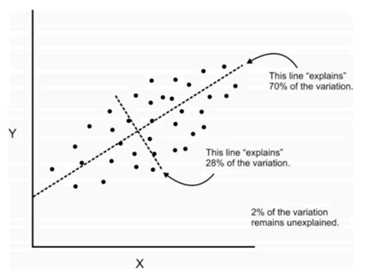

    +  First principal component is a linear combination of original predictor variables which captures thee maximum variance in the dataset. It determines the direction of highest variability in the data. This minimizes the sum of squared distance between a data point and the line. 
    + Second principle component captures the remaining variance and is uncorrelated to the first PC and these 2 are orthogonal.
    
###  <font color=blue>Algorithm</font>
1. Standardize data
2. Calculate the covariance matrix
2. Obtain the Eigenvectors and Eigenvalues from the covariance matrix 
3. Sort eigenvalues in descending order and choose the k eigenvectors that correspond to the k largest eigenvalues where k is the number of dimensions of the new feature subspace (k <= d)
4. Construct the projection matrix W from the selected k eigenvectors
5. Transform the original dataset X via W to obtain a k-dimensional feature subspace Y

### <font color=blue>Train model</font>

In [75]:
from sklearn.decomposition import PCA

pca = PCA()
pc = pca.fit_transform(X_train)

### <font color=blue>How many components?</font>

The biggest decision to make when running a PCA is how many components to keep. A common approach is to visualize the variance in order from highest to lowest, connecting them with a line. Upon visual inspection, the analyst will keep all the components whose variance falls above the point where the slope of the line changes the most drastically, also called thee "elbow"

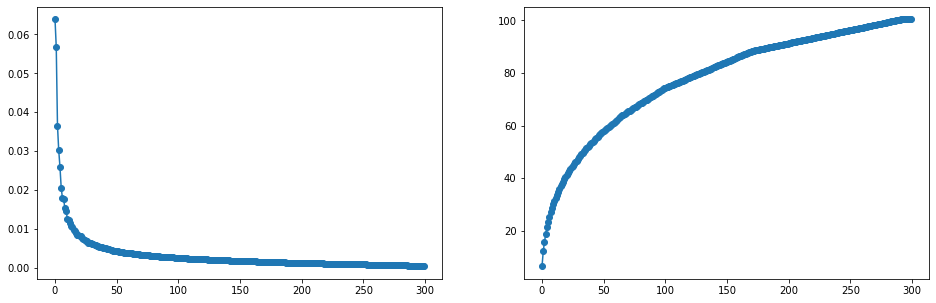

In [76]:
cumsum = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax[0].plot(pca.explained_variance_ratio_, '-o')
ax[1].plot(cumsum, '-o')
plt.show()

=> The fig on the left side illustrates the variance of each principal component and the fig on the right hand side is the cummulative sum of these principal components

=> It can be seen from the plot that even the 1st principal component explains very little about the data (variance = 0.06) and the slope of the line falls dramatically at around k=30 principal components and the cumulative is only around 40 percent and this may be not enought to explain the data. Hence, the analysis uses about the first 50 principal components and this explains about 60 percent of data

In [77]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(X_train)
print('Cummulative explained variation for the first 50 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

pca_df = pd.DataFrame(pca_result)
pca_df.head()

Cummulative explained variation for the first 50 principal components: 0.5731059312820435


0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19    20     21     22     23     24     25     26     27     28     29     30     31     32     33     34     35     36     37     38     39     40     41     42     43     44     45     46     47     48     49
0 -0.034  0.680  0.383  0.061 -0.216 -0.199 -0.066  0.025 -0.119 -0.382  0.227  0.030  0.022  0.021  0.021 -0.105  0.352  0.067 -0.156 -0.071 0.103  0.228  0.076  0.195 -0.284  0.377  0.049  0.056 -0.096  0.052  0.131  0.124  0.141 -0.145  0.074  0.061  0.067 -0.127 -0.229  0.074  0.103 -0.023 -0.127  0.171 -0.244 -0.054  0.082  0.016  0.187 -0.209
1 -0.508 -0.279 -0.201 -0.032  0.023  0.103  0.189  0.028  0.056 -0.271  0.076 -0.094  0.144  0.304 -0.322  0.416  0.067 -0.033 -0.007 -0.109 0.094 -0.351 -0.203  0.172 -0.099  0.216 -0.099  0.028  0.141 -0.091 -0.220  0.049 -0.143 -0.095  0.021  0.071 -0.180  0.063  0.097 -0.062  0.041  0.059  0.110 -0.137 -0.086 -0.012  0.131 -0.072 -0.088  0.002
2  1.155 -0.131  0.023 -0.187 -0.184  0.371 -0.003 -0.201 -0.164 -0.236 -0.160 -0.219 -0.017 -0.050  0.318  0.083 -0.012  0.048  0.016 -0.006 0.114 -0.267  0.200 -0.284 -0.041  0.121 -0.034 -0.128 -0.144 -0.063 -0.055  0.089 -0.078 -0.128 -0.022  0.028 -0.124  0.158  0.111 -0.202  0.123  0.104  0.008  0.155 -0.083 -0.051 -0.041 -0.018 -0.135  0.342
3 -0.190  0.469  0.770  0.013 -0.537  0.112  0.008 -0.168  0.121 -0.031  0.351  0.039  0.024 -0.009 -0.026 -0.182  0.194 -0.129 -0.013  0.298 0.071  0.082  0.015  0.027 -0.041 -0.128  0.061 -0.098  0.306 -0.231 -0.015  0.023 -0.220 -0.161  0.166 -0.020  0.100  0.093 -0.295 -0.031 -0.054 -0.120  0.008 -0.259 -0.089  0.025 -0.059 -0.050  0.024  0.100
4 -0.381  0.691  0.215  0.220 -0.446  0.374 -0.121  0.058  0.245 -0.080  0.087 -0.150  0.028  0.219  0.199  0.041  0.197 -0.050  0.002  0.181 0.014 -0.010  0.138  0.246 -0.220  0.150 -0.101 -0.271  0.025  0.007  0.363 -0.029  0.209  0.318 -0.195 -0.051  0.041  0.025  0.103  0.148 -0.092  0.001 -0.031  0.130  0.032  0.131 -0.002 -0.102  0.128 -0.212

### <font color=blue>Using TSNE algorithm to visualize data on 2D space</font>

1. t-Distributed Stochastic Neighbor Embedding (t-SNE) is **a non-linear technique for dimensonality reduction** that is particularly well suited for the visualization of high-dimensional datasets. **t-SNE gives us a feel or intuition of how the data is arranged in a high-dimensional space**. 


2. The idea of TSNE is **t-SNE minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding**. In this way, t-SNE maps the multi-dimensional data to a lower dimensional space and attempts to find patterns in the data by indentifying observed clusters based on similarity of data points with multiple features. However, after this process, the input features are no longer identifiable, and you cannot make any inference based only on the output of t-SNE. Hence it is mainly a data exploration and visualization technique.


3. It is highly recommended to use dimensionality reduction method to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.


4. **t-SNE vs. PCA**
    + PCA is a **linear dimension reduction technique** that seeks to **maximize variance and preserves large pairwise distances**. This can lead to poor visulization especially when dealing with non-linear manifold structures such as any geometric shape like: cylinder, ball, curve, etc.
PCA preserves only the global structure of the data. PCA is concerned with preserving large pairwise distances to maximize variance. 
    + TSNE is a **non-linear dimensionality reduction technique** preserves both the local and global structure. It uses the local relationship between data to map the high-dimensional data in two dimensions, **preserving only small pairwise distances or local similarities**. 

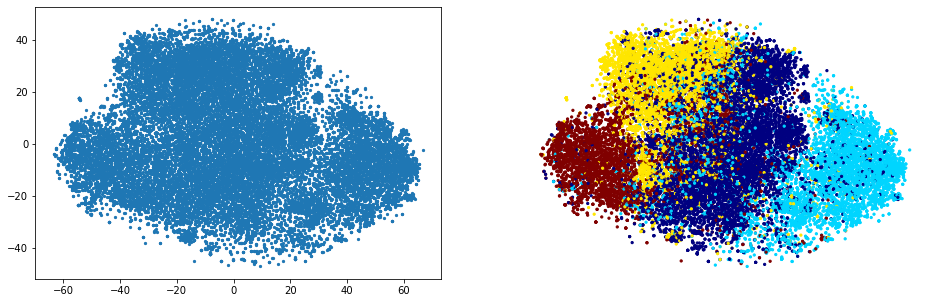

In [78]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(pca_df)

plot_cluster(X_train_tsne, y_train)

=> The fig on the left is the shape/pattern of data after being compressed using PCA and T-SNE, and the fig on the right hand side is the data with 4 colors representing 4 underlying classses

=> Assuming that we don't have label (hence the fig on the right hand side is not available), it can be seen on the left fig that the plot suggests there are around 3 clusters: left, middle and right

 ## <font color=red>**Stacked AutoEncoder**</font>
 
 ###  <font color=blue>Introduction</font>
 
1.	An auto-encoder is a kind of intersection between supervised and unsupervised learning that is commonly used for dimensionality reduction and feature discovery. More precisely, an auto-encoder is a feedforward neural network that is trained to predict the input itself. 


2. To prevent the system from learning the trivial identity mapping, the hidden layer in the middle is usually constrained to be a narrow bottleneck. The system can minimize the reconstruction error by ensuring the hidden units capture the most relevant aspects of the data which can be considered as the lower representation of data

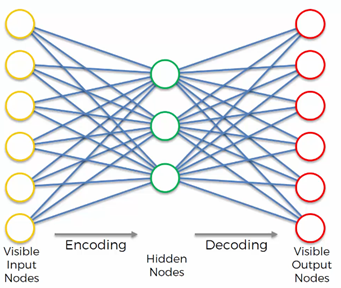


In [79]:
# Deep Learning libraries
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import datetime

In [80]:
tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()

# No of Neurons in each layer
input_dim = X_train.shape[1]
encoding1_dim = 80   # 60
encoding2_dim = 600
latent_dim = 18   #18

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(encoding1_dim), activation="relu")(input_layer)
encoder = Dense(int(encoding2_dim), activation='relu')(encoder)
#encoder = Dense(int(encoding3_dim), activation='tanh')(encoder)
encoder = Dense(int(latent_dim), activation='tanh')(encoder)
#decoder = Dense(int(encoding3_dim), activation='tanh')(encoder)
decoder = Dense(int(encoding2_dim), activation='tanh')(encoder)
decoder = Dense(int(encoding1_dim), activation='relu')(decoder)
decoder = Dense(int(input_dim), activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense (Dense)               (None, 80)                24080     
                                                                 
 dense_1 (Dense)             (None, 600)               48600     
                                                                 
 dense_2 (Dense)             (None, 18)                10818     
                                                                 
 dense_3 (Dense)             (None, 600)               11400     
                                                                 
 dense_4 (Dense)             (None, 80)                48080     
                                                                 
 dense_5 (Dense)             (None, 300)               24300 

In [81]:
# this models maps an input to its encoded representation
encoder_layer = Model(input_layer, encoder)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(int(latent_dim),))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3]
# create the decoder model
decoder_layer = Model(encoded_input, decoder_layer(encoded_input))

decoder_layer

In [82]:
nb_epoch = 30
batch_size = 100000
autoencoder.compile(optimizer='adam', loss='mse')

cp = ModelCheckpoint(filepath='autoencoder1.h5', save_best_only=True, verbose=0)
tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
t_ini = datetime.datetime.now()
history = autoencoder.fit(X_train, 
                          X_train, 
                          epochs=nb_epoch, 
                          #batch_size=batch_size, 
                          shuffle=True, 
                          validation_split=0.2, 
                          verbose=1
).history
t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))

df_history = pd.DataFrame(history)

Epoch 1/30
560/560 [==============================] - 4s 6ms/step - loss: 0.0904 - val_loss: 0.0784
Epoch 2/30
560/560 [==============================] - 3s 6ms/step - loss: 0.0718 - val_loss: 0.0660
Epoch 3/30
560/560 [==============================] - 3s 6ms/step - loss: 0.0609 - val_loss: 0.0527
Epoch 4/30
560/560 [==============================] - 4s 7ms/step - loss: 0.0454 - val_loss: 0.0415
Epoch 5/30
560/560 [==============================] - 4s 7ms/step - loss: 0.0367 - val_loss: 0.0333
Epoch 6/30
560/560 [==============================] - 4s 6ms/step - loss: 0.0302 - val_loss: 0.0280
Epoch 7/30
560/560 [==============================] - 3s 6ms/step - loss: 0.0255 - val_loss: 0.0231
Epoch 8/30
560/560 [==============================] - 4s 6ms/step - loss: 0.0203 - val_loss: 0.0178
Epoch 9/30
560/560 [==============================] - 3s 6ms/step - loss: 0.0176 - val_loss: 0.0177
Epoch 10/30
560/560 [==============================] - 5s 8ms/step - loss: 0.0170 - val_loss: 0.0153

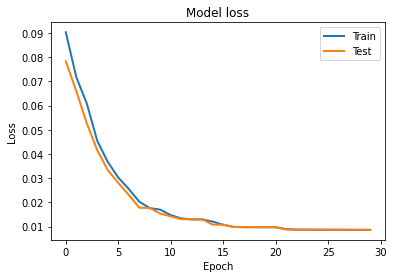

In [83]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [84]:
encoded = encoder_layer.predict(X_train)
ae_embeddings = pd.DataFrame(encoded)
print(ae_embeddings.shape)
ae_embeddings.head()

(22399, 18)


0      1      2      3      4     5      6      7      8      9      10     11     12     13     14     15     16    17
0 -0.141 -0.219 -0.153 -0.055  0.044 0.049  0.057 -0.097 -0.025  0.083 -0.014  0.039  0.181 -0.000 -0.100  0.121  0.049 0.644
1 -0.090 -0.046  0.008  0.143  0.092 0.048  0.049 -0.201 -0.087  0.068  0.182  0.086  0.012 -0.041  0.081 -0.047 -0.190 0.560
2 -0.160  0.080 -0.085  0.190 -0.143 0.272 -0.145  0.029  0.027 -0.008 -0.286 -0.161  0.049  0.002 -0.019  0.169  0.118 0.583
3 -0.150 -0.361 -0.240 -0.220  0.157 0.214  0.036  0.071 -0.002  0.111 -0.071 -0.108  0.088 -0.200 -0.061 -0.002 -0.022 0.648
4 -0.314 -0.354 -0.184  0.086  0.120 0.119  0.055  0.080  0.005 -0.014  0.029 -0.106 -0.039 -0.192 -0.045  0.041  0.015 0.605

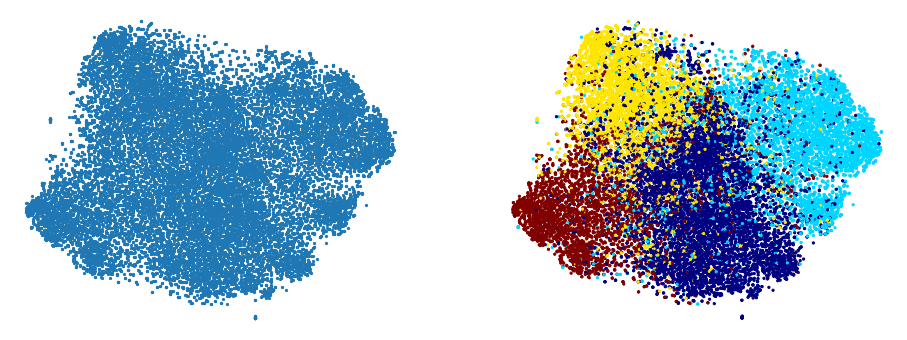

In [85]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=9)
X_train_tsne = tsne.fit_transform(ae_embeddings)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], s=5)
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, s=5, cmap="jet")
plt.axis("off")
plt.show()

=> The fig on the left is the shape/pattern of data after being compressed using PCA and T-SNE, and the fig on the right hand side is the underlying topic/class of the data

=> Assuming that we don't have label (hence the fig on the right hand side is not available), it can be seen on the left fig that the plot suggests there are around 4 clusters, 1 cluster at the top, and 2 clusters at middle, 1 cluster at the bottom

---
# <div class="alert alert-info"> 5. Clustering </div>

Now, it's time to apply clustering technique for solving topic modeling problem. Upon the visual inspection, we can see that the shapes of data have simple blobs, the k-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye. 

The K-Means algorithm is one of the most popular clustering methods. It is intended for situations in which all variables are of the quantitative type, and squared Euclidean distance is chosen as the dissimilarity measure

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest
1.	Choose the number of clusters, K stands for the number of clusters
2.	Select randomly k objects from the dataset as the initial cluster centers or means
3.	Calculate Euclidean distance between each point and each cluster (centroid), then assign datapoint to the closed centroid
4.	Adjust/Recalculate the centroids: For each of the k clusters update the cluster centroid by calculating the new mean values of all the data points in the cluster
5.	Repeat the last two steps until we can no longer assign the point to a centroid: Iteratively minimize the total within sum of square in a given cluster. That is, iterate until the cluster assignments stop changing or the maximum number of iterations is reached

Furthermore, this section uses 3 training dataset to compare the performance and find the best solution

In [86]:
from sklearn.cluster import KMeans
from scipy import stats

def specify_num_of_clusters(data, n_clusters):
    wcss = []
    for i in range(1, n_clusters):
        kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++')
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
        
    plt.plot(range(1,11), wcss)
    plt.title('Elbow Method')
    plt.xlabel("K Clusters")
    plt.ylabel("WCSS")
    plt.show()
    
    

def mapping_cluster_class(y, cluster):
    mapping = {}
    for class_id in np.unique(y):
        mode, _ = stats.mode(cluster[y==class_id])
        print(mode)
        mapping[mode[0]] = class_id
    return mapping


 ## <font color=red>**High dimensionality dataset**</font>

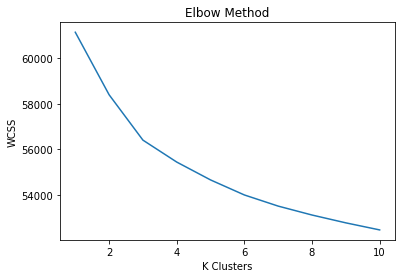

In [87]:
specify_num_of_clusters(X_train, 11)

In [88]:
kmeans = KMeans(n_clusters=4, random_state=9)
kmeans.fit(X_train)
kmeans_labels = kmeans.labels_
cluster_df = pd.DataFrame()
cluster_df['KMeans'] = kmeans_labels
cluster_class = mapping_cluster_class(y_train, kmeans_labels)
cluster_df['Cluster'] = cluster_df['KMeans'].map(cluster_class)

[0]
[1]
[3]
[2]


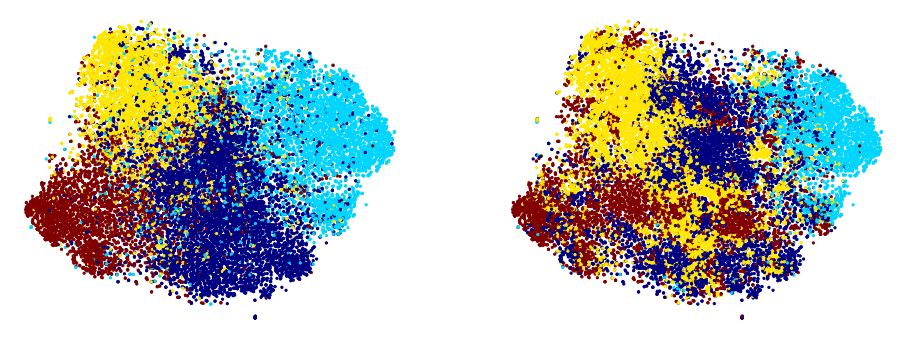

In [89]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=cluster_df['Cluster'], s=5, cmap="jet")
plt.axis("off")
plt.show()

+ The fig in the left hand side are the underlying distributions of data in 4 classes. The fig in the right hand side are the clustered data by KMeans

=> It's clearly to see that with hight dimensionality data (300 features), KMeans did not work very well, data in the same class (especially dark blue in the left fig) is mixed of many clusters 

 ## <font color=red>**PCA + KMeans**</font>

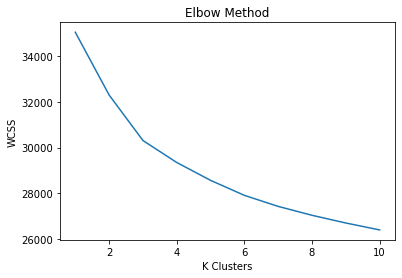

In [90]:
specify_num_of_clusters(pca_df, 11)

In [91]:
kmeans = KMeans(n_clusters=4, random_state=9)
kmeans.fit(pca_df)
PCA_Kmeans = kmeans.labels_
cluster_df = pd.DataFrame()
cluster_df['PCA_Kmeans'] = PCA_Kmeans
cluster_class = mapping_cluster_class(y_train, PCA_Kmeans)
cluster_df['Cluster'] = cluster_df['PCA_Kmeans'].map(cluster_class)

[1]
[2]
[3]
[0]


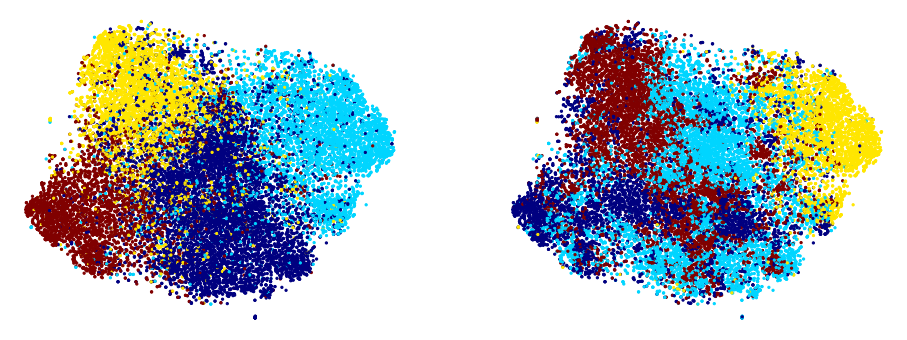

In [92]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=PCA_Kmeans, s=5, cmap="jet")
plt.axis("off")
plt.show()

+ The fig in the left hand side are the underlying distributions of data in 4 classes. The fig in the right hand side are the clustered data by KMeans

=> It's clearly to see that with hight dimensionality data (300 features), KMeans did not work very well, data in the same class (especially dark blue in the left fig) is mixed of many clusters 

 ## <font color=red>**AE + KMeans**</font>

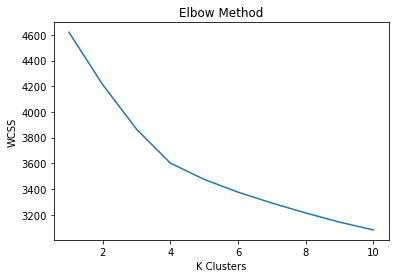

In [93]:
specify_num_of_clusters(ae_embeddings, 11)

In [94]:
ae_embeddings.head()

0      1      2      3      4     5      6      7      8      9      10     11     12     13     14     15     16    17
0 -0.141 -0.219 -0.153 -0.055  0.044 0.049  0.057 -0.097 -0.025  0.083 -0.014  0.039  0.181 -0.000 -0.100  0.121  0.049 0.644
1 -0.090 -0.046  0.008  0.143  0.092 0.048  0.049 -0.201 -0.087  0.068  0.182  0.086  0.012 -0.041  0.081 -0.047 -0.190 0.560
2 -0.160  0.080 -0.085  0.190 -0.143 0.272 -0.145  0.029  0.027 -0.008 -0.286 -0.161  0.049  0.002 -0.019  0.169  0.118 0.583
3 -0.150 -0.361 -0.240 -0.220  0.157 0.214  0.036  0.071 -0.002  0.111 -0.071 -0.108  0.088 -0.200 -0.061 -0.002 -0.022 0.648
4 -0.314 -0.354 -0.184  0.086  0.120 0.119  0.055  0.080  0.005 -0.014  0.029 -0.106 -0.039 -0.192 -0.045  0.041  0.015 0.605

In [95]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=25)
kmeans.fit(ae_embeddings)
AE_Kmeans = kmeans.labels_
cluster_df = pd.DataFrame()
cluster_df['AE_Kmeans'] = AE_Kmeans
cluster_class = mapping_cluster_class(y_train, AE_Kmeans)
cluster_df['Cluster'] = cluster_df['AE_Kmeans'].map(cluster_class)

[1]
[3]
[0]
[2]


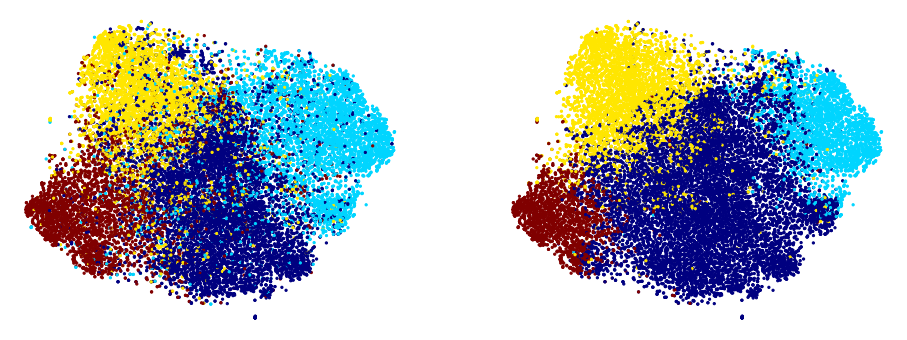

In [96]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=cluster_df['Cluster'], s=5, cmap="jet")
plt.axis("off")
plt.show()

+ The fig in the left hand side are the underlying distributions of data in 4 classes. The fig in the right hand side are the clustered data by KMeans

=> latent features compressed by Autoencoder is the best for applying KMeans. Here we can see that the cluster is quite similar with the underlying classes

In [97]:
mapping_number_label = y_train.map({0:'TRAVEL', 1:'FOOD & DRINK', 2:'BUSINESS', 3:'SPORTS'})
mapping_number_label[0]

'SPORTS'

## <font color=red>**LDA** </font>

1. LDA is one of the most popular topic modeling methods. LDA assumes that each document is generated by a statiscal generative process. The LDA makes two key assumptions:
    + Documents are a mixture of topics and
    + Topics are a mixture of words
  
2. For example, figure below shows a document with ten different words. This document could be assumed to be a mixture of three topics: tourism, facitilities and feedback. Each of these topic, in turn, is a mix of different collections of words
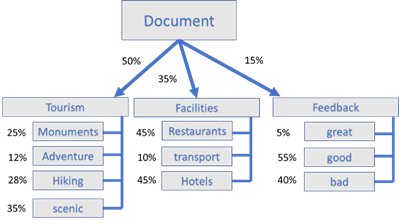

3. The aim of LDA is to find topics a document belongs to, basedon the words in it. In statistical language, first document using probability distribution to generate topics and later, these topics using the probability distribution to generate the words. The documents are known as the probability density (or distribution) of topics and the topics are the probability density (or distributions) of words

4. 'Dirichlet' indicates LDA's assumption that the distribution of topics in a document and the distribution of words in topics are both Dirichlet distributions. In LDA the topic distribution is assumed to have a sparse Dirichelet prior. The sparse Dirichlet priors encode the intuition that documents cover only a small set of topics and the topic use only a small set of words frequently

### 3.3. Feature Extraction with Tf-idf

Apply Tf-Idf bag of words model to convert from text to numeric value

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(max_features=10000, ngram_range=(1,1))
tv_corpus = tv.fit_transform(df_train['text_clean'])
tv_corpus = tv_corpus.toarray()

vocab = tv.get_feature_names()
print(len(vocab))
pd.DataFrame(np.round(tv_corpus, 2), columns=vocab).head(2)

10000


aaa  aaron   aau    ab  abandon  abbey  abbi  abbott   abc  abduljabbar  abid  abil   abl  ablaz  abnorm  aboard  abomin  abound  abraham  abroad  abruptli  absenc  absent  absinth  absolut  absorb  abstain  absurd  absurdli   abu  abund  abus  abyss  academ  academi   acc  acceler  accent  accentur  accept  access  accessori  accid  accident  acclaim  accommod  accompani  accomplish  accord  accordingli  account  accru  accumul  accur  accuraci  accus  accustom   ace   ach  achiev  acid  \
0 0.000  0.000 0.000 0.000    0.000  0.000 0.000   0.000 0.000        0.000 0.000 0.000 0.000  0.000   0.000   0.000   0.000   0.000    0.000   0.000     0.000   0.000   0.000    0.000    0.000   0.000    0.000   0.000     0.000 0.000  0.000 0.000  0.000   0.000    0.000 0.000    0.000   0.000     0.000   0.000   0.000      0.000  0.000     0.000    0.000     0.000      0.000       0.000   0.000        0.000    0.000  0.000    0.000  0.000     0.000  0.000     0.000 0.000 0.000   0.000 0.000   
1 0.000  0.000 0.000 0.000    0.000  0.000 0.000   0.000 0.000        0.000 0.000 0.000 0.000  0.000   0.000   0.000   0.000   0.000    0.000   0.000     0.000   0.000   0.000    0.000    0.000   0.000    0.000   0.000     0.000 0.000  0.000 0.000  0.000   0.000    0.000 0.000    0.000   0.000     0.000   0.000   0.000      0.000  0.000     0.000    0.000     0.000      0.000       0.000   0.000        0.000    0.000  0.000    0.000  0.000     0.000  0.000     0.000 0.000 0.000   0.000 0.000   

   acknowledg   acl  acosta  acoust  acqua  acquaint  acquir  acquisit   acr  acreag  acrobat  acronym  across   act  action  activ  activist  actor  actress  actual  acut    ad  adag  adam  adapt   add  addict  addit  address  adel  adelson  adequ  adher  adirondack  adjac  adjust  administr  admir  admiss  admit  admittedli   ado  adob  adolesc  adopt  ador  adorn  adrenalin  adri  adrian  adriat  adult  adulthood  advanc  advantag  advent  adventur  advers  advertis  advic  advis  advisor  \
0       0.000 0.000   0.000   0.000  0.000     0.000   0.000     0.000 0.000   0.000    0.000    0.000   0.000 0.000   0.000  0.000     0.000  0.000    0.000   0.000 0.000 0.000 0.000 0.000  0.000 0.000   0.000  0.000    0.000 0.000    0.000  0.000  0.000       0.000  0.000   0.000      0.000  0.000   0.000  0.000       0.000 0.000 0.000    0.000  0.000 0.000  0.000      0.000 0.000   0.000   0.000  0.000      0.000   0.000     0.000   0.000     0.000   0.000     0.000  0.000  0.000    0.000   
1       0.000 0.000   0.000   0.000  0.000     0.000   0.000     0.000 0.000   0.000    0.000    0.000   0.000 0.000   0.000  0.000     0.000  0.000    0.000   0.000 0.000 0.000 0.000 0.000  0.000 0.000   0.000  0.000    0.000 0.000    0.000  0.000  0.000       0.000  0.000   0.000      0.000  0.000   0.000  0.000       0.000 0.000 0.000    0.000  0.000 0.000  0.000      0.000 0.000   0.000   0.000  0.000      0.000   0.000     0.000   0.000     0.000   0.000     0.000  0.000  0.000    0.000   

   advisori  advoc  advocaci  aegean  aerial  aerospac  aesthet  aetna  afar   afc  affair  affect  affection  affili  affin  afford  afghanistan  aficionado  afloat  afraid  africa  african  africanamerican  aftermath  afternoon  aftershock  afterthought  afterward  afterwork   age  agenc  agenda  agent  ageold  aggi  aggrav  aggress  agil  agit   ago  agon  agoni  agre  agreement  agricultur  agua    ah   aha  ahead  ahem  ahol   aid   aig  aiguil   ail   aim  aint   air  airbag  airbnb  \
0     0.000  0.000     0.000   0.000   0.000     0.000    0.000  0.000 0.000 0.000   0.000   0.000      0.000   0.000  0.000   0.000        0.000       0.000   0.000   0.000   0.000    0.000            0.000      0.000      0.000       0.000         0.000      0.000      0.000 0.000  0.000   0.000  0.000   0.000 0.000   0.000    0.000 0.000 0.000 0.000 0.000  0.000 0.000      0.000       0.000 0.000 0.000 0.000  0.000 0.000 0.000 0.000 0.000   0.000 0.000 0.000 0.000 0.000   0.000   0.000   
1     0.

### 3.4. Decomposition

Any corpus, which is the collection of documents, can be represented as a document-word matrix (or document-term matrix) also known as DTM. LDA converts this document-word matrix into two other matrices:
+ A document-topic matrix () which would be the feature matrix we are looking for
+ A topic-term matrix: which helps us in looking at potential topics in the corpus

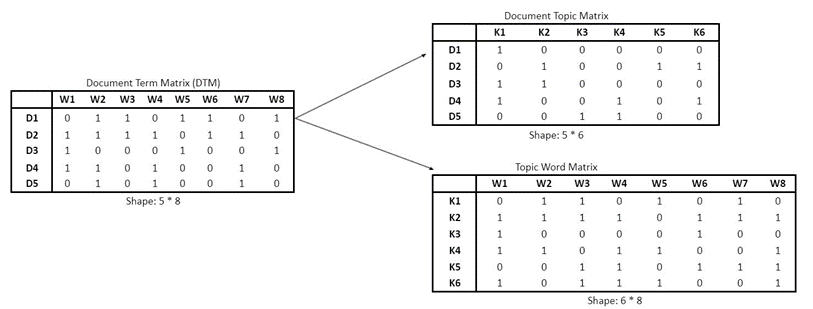

In [49]:
from sklearn.decomposition import LatentDirichletAllocation

#### Document-topic matrix

Document-topic matrix stores assignment (probability distribution) of each topic for a given document

In [50]:
df_train.head(12)

y                                           headline                                  short_description                                               text lang                                         text_clean
0         TRAVEL               Route 66, Ride for the Relay, Day 11  We all gathered for our second-to-the-last mor...  Route 66, Ride for the Relay, Day 11. We all g...   en  rout ride relay day gather secondtothelast mor...
1       BUSINESS                  Economic History and Thanksgiving  Thanksgiving is certainly one of my favorite h...  Economic History and Thanksgiving. Thanksgivin...   en  econom histori thanksgiv thanksgiv certainli o...
2   FOOD & DRINK  Drink Like The Truthiest American This Weekend...  Dust off your very best "good ol' Republican g...  Drink Like The Truthiest American This Weekend...   en  drink like truthiest american weekend channel ...
3       BUSINESS                                 Can We Trust Uber?  As I saw during my time in venture capital, it...  Can We Trust Uber?. As I saw during my time in...   en  trust uber saw time ventur capit littl thing r...
4       BUSINESS           The Hottest Cars at the Geneva Auto Show  You can count on the semi-annual Geneva auto s...  The Hottest Cars at the Geneva Auto Show. You ...   en  hottest car geneva auto show count semiannu ge...
5         TRAVEL  6 Perfect Places To Honeymoon And Leave Your S...  4. Fire Lookouts, U.S.A. Fire lookouts are use...  6 Perfect Places To Honeymoon And Leave Your S...   en  perfect place honeymoon leav smartphon fire lo...
6         TRAVEL  Versailles Commuter Train Designed In Homage T...  A commuter train in Paris has gotten a bit of ...  Versailles Commuter Train Designed In Homage T...   en  versail commut train design homag french palac...
7         TRAVEL   5 Las Vegas Clubs to Experience in 2013 (PHOTOS)  From longtime favorites to lesser-known gems, ...  5 Las Vegas Clubs to Experience in 2013 (PHOTO...   en  la vega club experi photo longtim favorit less...
8         TRAVEL                                    August In Paris  Imagine that eerily quiet Thanksgiving Day fee...  August In Paris. Imagine that eerily quiet Tha...   en  august pari imagin eerili quiet thanksgiv day ...
9   FOOD & DRINK                                    Yule Waste Less  These are the weeks of family, feasting, fun a...  Yule Waste Less. These are the weeks of family...   en  yule wast le week famili feast fun feast unfor...
10  FOOD & DRINK          Repeat After Us: Paleo Pizza IS NOT Pizza  Call it what you want, just stop trying to tri...  Repeat After Us: Paleo Pizza IS NOT Pizza. Cal...   en  repeat u paleo pizza pizza call want stop tri ...
11        SPORTS  Kyle Lowry Thinks Trump's Refugee Ban Is 'Abso...  Don't ask him to rephrase it without cursing, ...  Kyle Lowry Thinks Trump's Refugee Ban Is 'Abso...   en  kyle lowri think trump refuge ban absolut bull...

#### Topic-term matrix

**Other info**

Once the probabilities are estimated, finding the collections of words that represents a given topic can be done either by picking top 'r' probabilities of words or by setting a threshold for probability and picking only the words whose probabilities are greater than or equal to the threshold value.